Here, I will combine my results to create the official report card for the broadcasters

In [181]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [182]:
def load_scores():
    """Load all analysis results"""
    #excitement
    with open('test_results/excitement_scores.json', 'r') as f:  # Changed from excitement_score.json
        excitement_data = json.load(f)
        excitement_results = pd.DataFrame([
            {
                'broadcaster': broadcaster,
                'excitement_score': data['average_score']
            }
            for broadcaster, data in excitement_data.items()
        ])
    
    # bias here same way
    with open('test_results/bias_scores.json', 'r') as f:  # Changed from bias_score.json
        bias_data = json.load(f)
        bias_results = pd.DataFrame([
            {
                'broadcaster': broadcaster,
                'bias_score': data['home_bias']
            }
            for broadcaster, data in bias_data['broadcaster_bias'].items()
        ])
    
    # information density same way
    with open('test_results/information_density_results.json', 'r') as f:  # This one was correct
        density_data = json.load(f)
        info_density_results = pd.DataFrame([
            {
                'broadcaster': broadcaster,
                'info_density': data['average_entity_density']
            }
            for broadcaster, data in density_data.items()
        ])
    
    return excitement_results, bias_results, info_density_results

In [183]:
def normalize_with_bounds(value, column):
    """ need this for report card since gonna use 70-100 scale for passing grades"""
    if column == 'excitement_score':
        return value * 100  # Assuming excitement is already 0-1
    elif column == 'bias_score':
        return 100 - (value * 100)  # Invert and scale
    elif column == 'info_density':
        # Scale based on observed ranges in sports commentary
        return (value / 0.08) * 100  # Assuming 0.08 is a reasonable maximum

In [184]:
def create_broadcaster_report_card(excitement_results, bias_results, info_density_results):
    """Create a report card using the three main metrics with consistent weighting"""
    
    # Merge all results on broadcaster
    report_card = excitement_results.merge(
        bias_results, on='broadcaster'
    ).merge(
        info_density_results, on='broadcaster'
    ).set_index('broadcaster')
    
    # Normalize scores this way to get raw metric into 70-100 scale range.... messy but logic is here
    # 1. Excitement - start range at 0, divide to norm, multiply to spread across 35 pts
    report_card['excitement_score_normalized'] = (report_card['excitement_score'] - 0.20) * (95 - 60) / (0.23 - 0.20) + 60
    
    # 2. Bias (original scale ~0.50-0.52, lower is better)
    # 0.53 is max bias, so invert to get 0-1, then scale to 30 pts
    report_card['bias_score_normalized'] = (0.53 - report_card['bias_score']) * (90 - 60) / (0.53 - 0.50) + 60
    
    # 3. Information Density (original scale ~0.052-0.061)
    # 0.08 is max density, so scale to 30 pts
    report_card['info_density_normalized'] = (report_card['info_density'] - 0.05) * (90 - 60) / (0.061 - 0.05) + 60
    
    # Clip normalized scores
    # clip allows me to keep 70-100 scale
    for col in ['excitement_score_normalized', 'bias_score_normalized', 'info_density_normalized']:
        report_card[col] = report_card[col].clip(0, 100)
    
    # just going to use even weights for this research although probably color comm is more important
    weights = {
        'excitement_score_normalized': 0.333,
        'bias_score_normalized': 0.333,
        'info_density_normalized': 0.333
    }
    
    # Calculate weighted final grade
    report_card['final_grade'] = sum(
        report_card[col] * weight 
        for col, weight in weights.items()
    )
    
    # Assign letter grades using same scale for all metrics
    for metric in ['excitement_score', 'bias_score', 'info_density']:
        normalized_col = f'{metric}_normalized'
        report_card[f'{metric}_letter'] = pd.cut(
            report_card[normalized_col],
            bins=[0, 70, 75, 80, 90, 100],
            labels=['F', 'D', 'C', 'B', 'A']
        )
    
    # Overall letter grade
    report_card['letter_grade'] = pd.cut(
        report_card['final_grade'],
        bins=[0, 60, 70, 80, 90, 100],
        labels=['F', 'D', 'C', 'B', 'A']
    )
    
    return report_card



In [185]:
def visualize_report_card(report_card):
    """Create visualizations with consistent weighting and 70-100 scale heatmap"""
    plt.style.use('default')
    
    fig = plt.figure(figsize=(20, 16))
    
    ax1 = plt.subplot(221)  # top left
    ax2 = plt.subplot(222)  # top right
    
    # 1. Overall Grade Plot
    bars = sns.barplot(
        data=report_card.reset_index(),
        x='broadcaster',
        y='final_grade',
        ax=ax1
    )
    
    # Add score labels with larger font size
    for i, bar in enumerate(bars.patches):
        score = bar.get_height()
        bars.text(
            bar.get_x() + bar.get_width()/2,
            score + 0.5,  # Adjusted position slightly
            f'{score:.1f}',
            ha='center',
            va='bottom',
            fontsize=14,  # Increased from 10 to 14
            fontweight='bold'  # Made text bold
        )
    
    ax1.set_title('Overall Broadcaster Grades', fontsize=14)
    ax1.set_ylim(70, 100)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Individual Metrics Heatmap
    metrics = ['excitement_score', 'bias_score', 'info_density']
    
    # Create arrays for normalized scores and letter grades
    numerical_data = np.zeros((len(report_card.index), len(metrics)))
    letter_data = np.empty((len(report_card.index), len(metrics)), dtype='object')
    
    for i, metric in enumerate(metrics):
        normalized_col = f'{metric}_normalized'
        letter_col = f'{metric}_letter'
        numerical_data[:, i] = report_card[normalized_col]
        letter_data[:, i] = report_card[letter_col]
    
    # Create heatmap with 70-100 scale
    sns.heatmap(
        numerical_data,
        annot=letter_data,
        fmt='',
        cmap='RdYlGn',
        ax=ax2,
        cbar_kws={'label': 'Score (70-100)'},
        vmin=70,
        vmax=100,
        xticklabels=metrics,
        yticklabels=report_card.index
    )
    ax2.set_title('Individual Metrics Grades', fontsize=14)
    
    plt.tight_layout()
    plt.show()

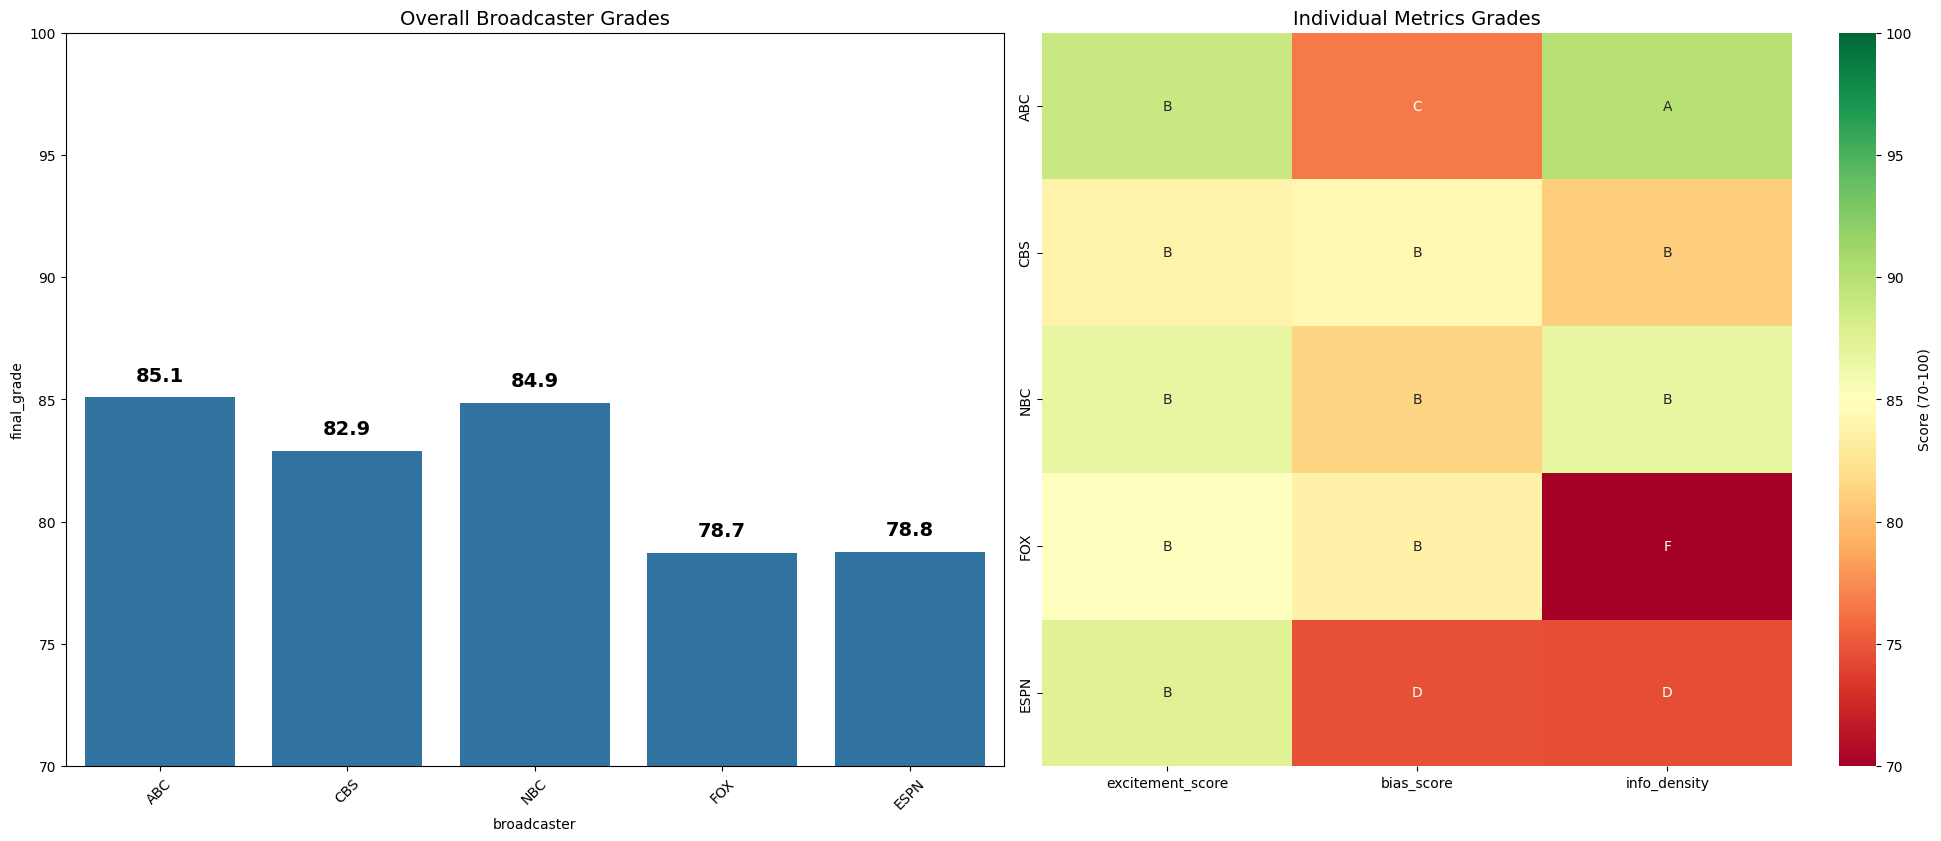

In [186]:

excitement_results, bias_results, info_density_results = load_scores()

report_card = create_broadcaster_report_card(excitement_results, bias_results, info_density_results)
visualize_report_card(report_card)
    
